# First Trend Strategy

### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.stats.multitest as mt
import arch.bootstrap as boot
import pyalgotrade.barfeed.csvfeed as csvfeed
import pyalgotrade.bar as bar
import pyalgotrade.strategy as strategy
import pyalgotrade.technical.ma as ma
import pyalgotrade.broker as broker
import pyalgotrade.stratanalyzer.returns as ret
import pyalgotrade.plotter as plotter
import datetime as dt
import itertools
import time

### Create Strategy Class

In [4]:
class TrendStrategy1(strategy.BacktestingStrategy):

    # 2.1. Define Strategy Initialization Function
    def __init__(self, feed, instrument, nfastSMA, nslowSMA):
        super(TrendStrategy1, self).__init__(feed, 10000)
        self.position = None
        self.instrument = instrument
        self.setUseAdjustedValues(True)
        self.fastsma = ma.SMA(feed[instrument].getPriceDataSeries(), nfastSMA)
        self.slowsma = ma.SMA(feed[instrument].getPriceDataSeries(), nslowSMA)

    # 2.2. Define Get Technical Indicators Functions
    def getfastSMA(self):
        return self.fastsma

    def getslowSMA(self):
        return self.slowsma

    # 2.3. Define Overriding Strategy Functions

    # onEnterCanceled: Get notified when order submitted to enter a position was canceled and update position
    def onEnterCanceled(self, position):
        self.position = None

    # onExitOk: Get notified when order submitted to exit a position was filled and update position
    def onExitOk(self, position):
        self.position = None

    # onExitCanceled: Get notified when order submitted to exit a position was canceled and re-submit order
    def onExitCanceled(self, position):
         self.position.exitMarket()

    # 2.4. Define Trading Strategy Function

    # Trend-Following Strategy
    # Enter Long Order = Buy when Fast SMA > Slow SMA,
    # Exit Order = Sell when Fast SMA < Slow SMA

    def onBars(self, bars):
        if self.slowsma[-1] is None:
            return

        if self.position is None:
            if self.fastsma[-1] > self.slowsma[-1]:
                # 95% equity investment for difference between order day Close price and next day Open price
                # number of shares can also be a fixed quantity for all transactions (ex. self.shares = 10)
                self.shares = int(self.getBroker().getCash() * 0.95 / bars[self.instrument].getPrice())
                self.position = self.enterLong(self.instrument, self.shares, goodTillCanceled=True)

        elif self.fastsma[-1] < self.slowsma[-1] and not self.position.exitActive():
            self.position.exitMarket()


### Define Run Strategy Function

In [7]:
def TrendStrategyRun1(nfastSMA, nslowSMA, chart):

    # 3.1. Create Instruments object with stock tickers
    instruments = ['SPY']

    # 3.2. Load CSV Feed previously downloaded or read
    feed = csvfeed.GenericBarFeed(bar.Frequency.DAY)
    feed.addBarsFromCSV(instruments[0], './Advanced-Trading-Analysis-Data.txt', skipMalformedBars=True)

    # 3.3. Evaluate Strategy with CSV Feed and Technical Indicator Parameters
    trendStrategy1 = TrendStrategy1(feed, instruments[0], nfastSMA, nslowSMA)

    # 3.4. Set Strategy Commission
    trendStrategy1.getBroker().setCommission(broker.backtesting.FixedPerTrade(6))

    # 3.5. Attach Strategy Trading Statistics Analyzers
    retAnalyzer = ret.Returns(maxLen=2518)
    trendStrategy1.attachAnalyzer(retAnalyzer)

    # 3.6. Attach Strategy Plotter
    plt = plotter.StrategyPlotter(trendStrategy1, plotPortfolio=False)
    plt.getInstrumentSubplot('SPY').addDataSeries('Fast SMA', trendStrategy1.getfastSMA())
    plt.getInstrumentSubplot('SPY').addDataSeries('Slow SMA', trendStrategy1.getslowSMA())

    # 3.7. Run Strategy
    trendStrategy1.run()

    # 3.8. Calculate Strategy Returns
    datesReturns = retAnalyzer.getReturns().getDateTimes()[:]
    dailyReturns = retAnalyzer.getReturns()[:]
    dailyReturns = pd.DataFrame(dailyReturns).set_index(pd.DatetimeIndex(datesReturns))

    # 3.9. Plot Strategy
    if chart == True:
        plt.plot(fromDateTime=dt.datetime(2016, 1, 1), toDateTime=dt.datetime(2016, 12, 31))

    return dailyReturns

### Plot Estrategy Example

C:\Users\evillarraga\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


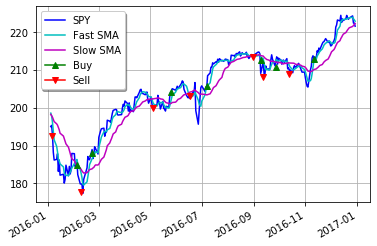

,0
2007-01-03,0.000000
2007-01-04,0.000000
2007-01-05,0.000000
2007-01-08,0.000000
2007-01-09,0.000000
2007-01-10,0.000000
2007-01-11,0.000000
2007-01-12,0.000000
2007-01-16,0.000000
2007-01-17,0.000000


In [8]:
TrendStrategyRun1(5, 20, True)

### Do Strategy Parameters Optimization and Calculate Performance Metrics

##### Create Strategy Optimization Parameters Combinations

In [9]:
nfastSMA = (5, 15)
nslowSMA = (20, 30)
pool = [nfastSMA, nslowSMA]

##### Calculate Benchmark Daily Returns

In [11]:
data = pd.read_csv('./Advanced-Trading-Analysis-Data.txt', index_col='Date Time', parse_dates=True)
trend1DailyReturns = data['Adj Close'].pct_change(1)
trend1DailyReturns[0] = 0
trend1DailyReturns = pd.DataFrame(trend1DailyReturns)

##### Do Strategy Optimization

In [12]:
trend1StartOptimization = time.time()
print('')
print('== Strategy Parameters Optimization ==')
print('')
print('Parameters Combinations (nfastSMA, nslowSMA):')
for n in itertools.product(*pool):
    print(n)
    trend1DailyReturns.insert(len(trend1DailyReturns.columns), n, TrendStrategyRun1(n[0], n[1], False))
trend1EndOptimization = time.time()
trend1DailyReturns.columns = ['B&H', 'Tr1Ret1', 'Tr1Ret2', 'Tr1Ret3', 'Tr1Ret4']
print('')
print('Optimization Running Time: ', round(trend1EndOptimization - trend1StartOptimization, 4), ' seconds')
print('')


== Strategy Parameters Optimization ==

Parameters Combinations (nfastSMA, nslowSMA):
(5, 20)
(5, 30)
(15, 20)
(15, 30)

Optimization Running Time:  1.016  seconds



##### Define Cumulative Returns and Performance Metrics Functions

In [13]:
def CumulativeReturns(dailyReturns):
    cumulativeReturns = np.cumprod(dailyReturns + 1) ** (252 / len(dailyReturns)) - 1
    return cumulativeReturns

def PerformanceMetrics(dailyReturns):
    annualizedReturn = (np.cumprod(dailyReturns + 1) ** (252 / len(dailyReturns)) - 1)[-1]
    annualizedStdDev = np.std(dailyReturns) * np.sqrt(252)
    annualizedSharpe = annualizedReturn / annualizedStdDev
    return annualizedReturn, annualizedStdDev, annualizedSharpe

##### Chart Cumulative Returns Comparison

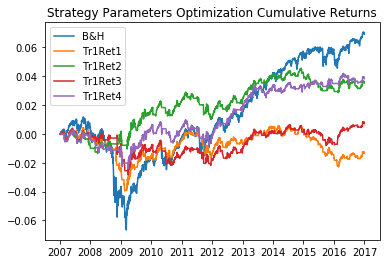

In [14]:
trend1CumulativeReturns = trend1DailyReturns.apply(CumulativeReturns, axis=0)
plt.plot(trend1CumulativeReturns['B&H'], label='B&H')
plt.plot(trend1CumulativeReturns['Tr1Ret1'], label='Tr1Ret1')
plt.plot(trend1CumulativeReturns['Tr1Ret2'], label='Tr1Ret2')
plt.plot(trend1CumulativeReturns['Tr1Ret3'], label='Tr1Ret3')
plt.plot(trend1CumulativeReturns['Tr1Ret4'], label='Tr1Ret4')
plt.title('Strategy Parameters Optimization Cumulative Returns')
plt.legend(loc='upper left')
plt.show()

##### Calculate Performance Metrics and Print Summary Table

In [15]:
trend1PerformanceMetrics = trend1DailyReturns.apply(PerformanceMetrics, axis=0)
trend1PerformanceSummary = [{'0': 'Annualized:', '1': 'B&H', '2': 'Tr1Ret1', '3': 'Tr1Ret2', '4': 'Tr1Ret3',
                             '5': 'Tr1Ret4'},
        {'0': 'Return',
         '1': np.round(trend1PerformanceMetrics[0][0], 4), '2': np.round(trend1PerformanceMetrics[1][0], 4),
         '3': np.round(trend1PerformanceMetrics[2][0], 4), '4': np.round(trend1PerformanceMetrics[3][0], 4),
         '5': np.round(trend1PerformanceMetrics[4][0], 4)},
        {'0': 'Standard Deviation',
         '1': np.round(trend1PerformanceMetrics[0][1], 4), '2': np.round(trend1PerformanceMetrics[1][1], 4),
         '3': np.round(trend1PerformanceMetrics[2][1], 4), '4': np.round(trend1PerformanceMetrics[3][1], 4),
         '5': np.round(trend1PerformanceMetrics[4][1], 4)},
        {'0': 'Sharpe Ratio (Rf=0%)',
         '1': np.round(trend1PerformanceMetrics[0][2], 4), '2': np.round(trend1PerformanceMetrics[1][2], 4),
         '3': np.round(trend1PerformanceMetrics[2][2], 4), '4': np.round(trend1PerformanceMetrics[3][2], 4),
         '5': np.round(trend1PerformanceMetrics[4][2], 4)}]
trend1PerformanceSummary = pd.DataFrame(trend1PerformanceSummary)
print('')
print('== Strategy Parameters Optimization Performace Summary ==')
print('')
print(trend1PerformanceSummary)
print('')


== Strategy Parameters Optimization Performace Summary ==

                      0       1        2        3        4        5
0           Annualized:     B&H  Tr1Ret1  Tr1Ret2  Tr1Ret3  Tr1Ret4
1                Return   0.069  -0.0136   0.0352   0.0071   0.0382
2    Standard Deviation  0.2084   0.1126   0.1104   0.1134   0.1106
3  Sharpe Ratio (Rf=0%)  0.3309  -0.1207   0.3186   0.0623   0.3449



### Do Multiple Hypothesis Testing P-Values Adjustments

##### Calculate Multiple Hypothesis Testing P-Values

In [16]:
trend1MultipleTTests = trend1DailyReturns.iloc[:, 1:5].apply(st.ttest_1samp, axis=0, popmean=0, nan_policy='omit')
trend1MultiplePValues = (trend1MultipleTTests[0][1], trend1MultipleTTests[1][1], trend1MultipleTTests[2][1],
                         trend1MultipleTTests[3][1])

##### Adjust Multiple Hypothesis Testing P-Values Calculations

In [17]:
trend1MultiplePValuesFWE = mt.multipletests(trend1MultiplePValues, alpha=0.05, method='bonferroni',
                                                   is_sorted=False, returnsorted=False)
trend1MultiplePValuesFDR = mt.multipletests(trend1MultiplePValues, alpha=0.05, method='fdr_bh',
                                                   is_sorted=False, returnsorted=False)

##### Print Multiple Hypothesis Testing P-Values Adjustment Summary Table

In [18]:
trend1MultiplePValuesSummary = [{'0': '', '1': 'Tr1Ret1', '2': 'Tr1Ret2', '3': 'Tr1Ret3', '4': 'Tr1Ret4'},
        {'0': 'PValues',
         '1': np.round(trend1MultiplePValues[0], 4), '2': np.round(trend1MultiplePValues[1], 4),
         '3': np.round(trend1MultiplePValues[2], 4), '4': np.round(trend1MultiplePValues[3], 4)},
        {'0': 'PValues FWE',
         '1': np.round(trend1MultiplePValuesFWE[1][0], 4), '2': np.round(trend1MultiplePValuesFWE[1][1], 4),
         '3': np.round(trend1MultiplePValuesFWE[1][2], 4), '4': np.round(trend1MultiplePValuesFWE[1][3], 4)},
        {'0': 'PValues FDR',
         '1': np.round(trend1MultiplePValuesFDR[1][0], 4), '2': np.round(trend1MultiplePValuesFDR[1][1], 4),
         '3': np.round(trend1MultiplePValuesFDR[1][2], 4), '4': np.round(trend1MultiplePValuesFDR[1][3], 4)}]
trend1MultiplePValuesSummary = pd.DataFrame(trend1MultiplePValuesSummary)
print('')
print('== Multiple Hypothesis Testing P-Values Adjustments ==')
print('')
print(trend1MultiplePValuesSummary)
print('')


== Multiple Hypothesis Testing P-Values Adjustments ==

             0        1        2        3        4
0               Tr1Ret1  Tr1Ret2  Tr1Ret3  Tr1Ret4
1      PValues   0.8367   0.2444   0.7069   0.2131
2  PValues FWE        1   0.9777        1   0.8523
3  PValues FDR   0.8367   0.4888   0.8367   0.4888



### Do Individual Time Series Bootstrap P-Value Multiple Comparison Adjustment

##### Define Bootstrap Mean Function

In [19]:
def bmean(x):
    return x.mean(0)

##### Do Individual Time Series Bootstrap

In [20]:
trend1StartBoot = time.time()
print('')
print('== Individual Time Series Bootstrap ==')
print('')
trend1Boot = boot.CircularBlockBootstrap(block_size=10, x=trend1DailyReturns.iloc[:, 4])
trend1BootMeans = trend1Boot.apply(func=bmean, reps=1000)
trend1BootIntervals = trend1Boot.conf_int(func=bmean, reps=1000, method='percentile', size=0.95, tail='two')
trend1EndBoot = time.time()
print('')
print('Bootstrap Running Time: ', round(trend1EndBoot - trend1StartBoot, 4), ' seconds')
print('')


== Individual Time Series Bootstrap ==


Bootstrap Running Time:  0.3221  seconds



##### Chart Individual Time Series Bootstrap Histogram

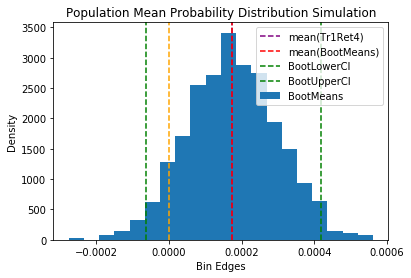

In [21]:
plt.hist(trend1BootMeans, bins=20, density=True, label='BootMeans')
plt.title('Population Mean Probability Distribution Simulation')
plt.axvline(x=np.mean(trend1DailyReturns.iloc[:, 4]), color='purple', linestyle='--', label='mean(Tr1Ret4)')
plt.axvline(x=np.mean(trend1BootMeans), color='red', linestyle='--', label='mean(BootMeans)')
plt.axvline(x=0, color='orange', linestyle='--')
plt.axvline(x=trend1BootIntervals[0], color='green', linestyle='--', label='BootLowerCI')
plt.axvline(x=trend1BootIntervals[1], color='green', linestyle='--', label='BootUpperCI')
plt.ylabel('Density')
plt.xlabel('Bin Edges')
plt.legend(loc='upper right')
plt.show()

##### Calculate Individual Time Series Bootstrap P-Value

In [22]:
trend1BootPValue = 2 * min(np.mean(trend1BootMeans <= 0), np.mean(trend1BootMeans > 0))

##### Adjust Individual Time Series Bootstrap P-Value Calculation

In [23]:
trend1BootPValueFWE = 1 - (1 - trend1BootPValue) ** 4
print('')
print('== Individual Time Series Bootstrap Hypothesis Testing ==')
print('')
print('Tr1Ret4 P-Value:', np.round(trend1BootPValue, 4))
print('Tr1Ret4 P-Value FWE:', np.round(trend1BootPValueFWE, 4))


== Individual Time Series Bootstrap Hypothesis Testing ==

Tr1Ret4 P-Value: 0.158
Tr1Ret4 P-Value FWE: 0.4974
